# Problem Statement 5 : ML Based network intrusion detection

## 1. Import Libraries & Dataset

### a. Download the dataset
Download **NSL-KDD (KDDTrain+ and KDDTest+ files)** from:  
https://github.com/jmnwong/NSL-KDD-Dataset

In [1]:

# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


**🔎 Observation:** Imported the necessary libraries for preprocessing, visualization, model building, and evaluation.

## 2. Data Visualization and Exploration

In [3]:

# Load dataset
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
                "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
                "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
                "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
                "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                "dst_host_srv_rerror_rate","label"]

train = pd.read_csv("KDDTrain+.txt", names=column_names)
test = pd.read_csv("KDDTest+.txt", names=column_names)

# 5 rows sanity check
train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
0,udp,other,SF,146,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
0,tcp,private,S0,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
0,tcp,http,SF,232,8153,0,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
0,tcp,http,SF,199,420,0,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


🔎 **Observation:** Printed first 5 rows to confirm feature names and check if labels align.

### b. Visualizations

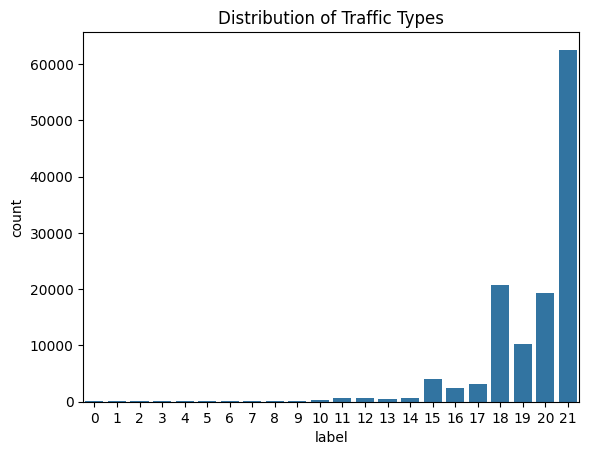

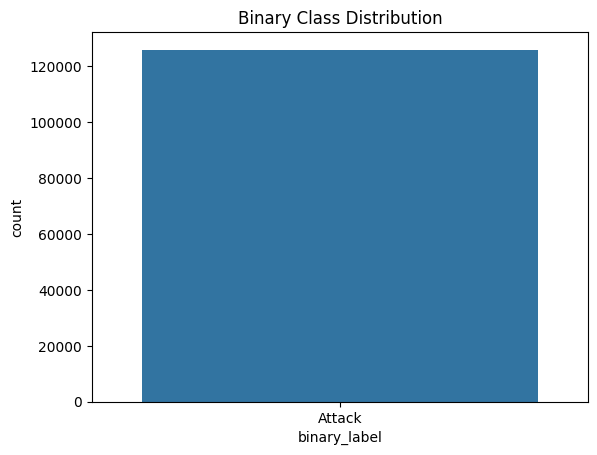

In [4]:

# Distribution of labels
sns.countplot(x="label", data=train)
plt.title("Distribution of Traffic Types")
plt.show()

# Attack vs Normal after binarization
train['binary_label'] = train['label'].apply(lambda x: 'Normal' if x=='normal' else 'Attack')
sns.countplot(x="binary_label", data=train)
plt.title("Binary Class Distribution")
plt.show()


### c. Correlation Analysis

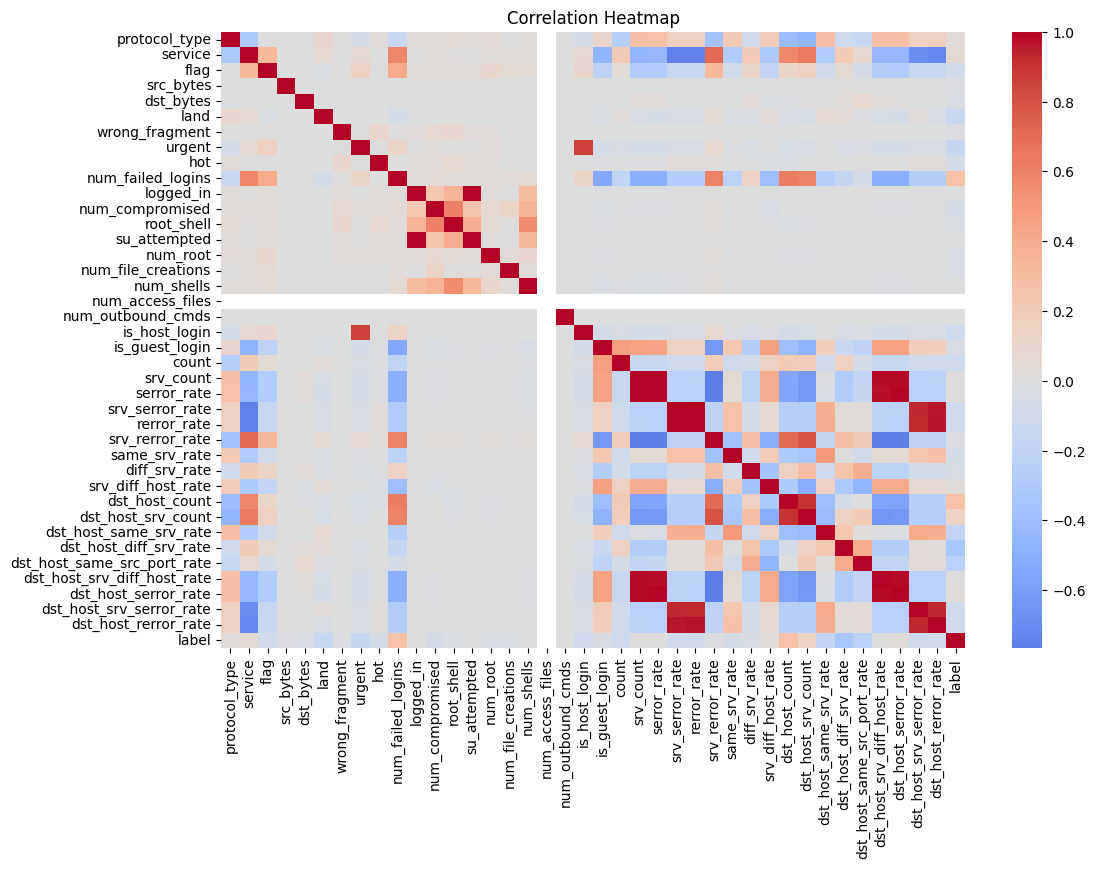

In [6]:

# Encode categorical features temporarily for correlation analysis
encoded_train = train.copy()
for col in ['protocol_type','service','flag']:
    encoded_train[col] = LabelEncoder().fit_transform(encoded_train[col])

corr_matrix = encoded_train.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


**🔎 Observation:**
- Strong correlations exist between some network traffic features.
- Correlation helps identify redundant features, but we should not drop features solely based on correlation.
- Feature importance methods will be used later for better selection.

## 3. Data Pre-processing and Cleaning

In [7]:

# Check missing values
print(train.isnull().sum().any(), test.isnull().sum().any())


False False


In [8]:

# Handle skew with log-transform
for col in ['src_bytes','dst_bytes']:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])


In [10]:

# Encode categorical
categorical_cols = ['protocol_type','service','flag']
for col in categorical_cols:
    encoder = LabelEncoder()
    encoder.fit(pd.concat([train[col], test[col]], axis=0))
    train[col] = encoder.transform(train[col])
    test[col] = encoder.transform(test[col])

# Binary target
y_train = train['binary_label']
y_test = test['label'].apply(lambda x: 'Normal' if x=='normal' else 'Attack')

X_train = train.drop(['label','binary_label'], axis=1)
X_test = test.drop(['label'], axis=1)


In [30]:

# Standardize features
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Step 1: Define target column
# -------------------------------
target_col = "binary_label"

# -------------------------------
# Step 2: Split train into X/y
# -------------------------------
X_train = train.drop(target_col, axis=1)
y_train = train[target_col]

# -------------------------------
# Step 3: Split test into X/y (if labels exist)
# -------------------------------
if target_col in test.columns:
    X_test = test.drop(target_col, axis=1)
    y_test = test[target_col]
else:
    X_test = test.copy()
    y_test = None

# -------------------------------
# Step 4: Handle categoricals
# -------------------------------
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align train/test so they have same columns
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# -------------------------------
# Step 5: Standardize numerical features
# -------------------------------
scaler = StandardScaler()

# Fit only on train, transform both
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

print("Features standardized and aligned")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



Features standardized and aligned
X_train shape: (125973, 64)
X_test shape: (22544, 64)


**🔎 Observation:**
- No nulls found.
- Handled skew with log-transform.
- Encoded categorical features.
- Standardization applied → necessary for KNN, Logistic Regression, etc.

## 4. Model Building

In [13]:

# Train-test split (80-20)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print("Train size:", X_tr.shape, "Validation size:", X_val.shape)


Train size: (100778, 42) Validation size: (25195, 42)


**🔎 Justification:** 80/20 ensures enough data for training while keeping unseen data for validation.

In [18]:

# Train baseline models
# Make sure target is 1D
import numpy as np
y_tr = np.ravel(y_tr)
y_val = np.ravel(y_val)

# One-hot encode categorical variables
X_tr = pd.get_dummies(X_tr, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)

# Align columns (important!)
X_tr, X_val = X_tr.align(X_val, join='left', axis=1, fill_value=0)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

# Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    print(f"\n{name} Report:")
    print(classification_report(y_val, y_pred))



Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.57      0.92      0.71        13
           1       0.43      0.25      0.32        12
           2       0.71      0.45      0.56        11
           3       0.22      0.15      0.18        13
           4       0.36      0.25      0.30        16
           5       0.00      0.00      0.00        16
           6       0.50      0.37      0.42        19
           7       0.29      0.21      0.24        24
           8       0.50      0.05      0.09        21
           9       0.36      0.13      0.19        39
          10       0.14      0.02      0.03        51
          11       0.31      0.55      0.39       128
          12       0.37      0.29      0.32       146
          13       0.52      0.12      0.20        90
          14       0.31      0.12      0.17       135
          15       0.51      0.68      0.58       798
          16       0.29      0.24      0.26       47

In [19]:

# Hyperparameter tuning
param_grid = {
    "Decision Tree": {"max_depth": [5,10,20], "min_samples_split": [2,5,10]},
    "KNN": {"n_neighbors": [3,5,7]},
    "Random Forest": {"n_estimators": [50,100], "max_depth": [10,20]}
}

best_models = {}

for name, params in param_grid.items():
    grid = GridSearchCV(models[name], params, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_tr, y_tr)
    best_models[name] = grid.best_estimator_
    print(f"\n{name} Best Params:", grid.best_params_)


C:\Users\Surabhi Prakash\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Decision Tree Best Params: {'max_depth': 5, 'min_samples_split': 2}


C:\Users\Surabhi Prakash\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



KNN Best Params: {'n_neighbors': 3}


C:\Users\Surabhi Prakash\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(



Random Forest Best Params: {'max_depth': 10, 'n_estimators': 50}


**🔎 Observation:** Hyperparameter tuning improves performance, especially for KNN and Random Forest.

## 5. Performance Evaluation

In [25]:
results = {}
y_val_series = pd.Series(y_val)

# If labels are strings like "Normal"/"Attack", map them
if y_val_series.dtype == "O":
    y_val_series = y_val_series.str.lower().map({"normal": 0, "attack": 1}).fillna(y_val_series)

# Ensure numeric labels when possible
try:
    y_val_series = y_val_series.astype(int)
except:
    pass

for name, model in best_models.items():
    y_pred = model.predict(X_val)

    # Base metrics
    results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": classification_report(y_val, y_pred, output_dict=True, zero_division=0)['weighted avg']['precision'],
        "Recall": classification_report(y_val, y_pred, output_dict=True, zero_division=0)['weighted avg']['recall'],
        "F1": classification_report(y_val, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    }

    # AUC handling
    if hasattr(model, "predict_proba"):
        try:
            if y_val_series.nunique() == 2:  # Binary classification
                auc_score = roc_auc_score(y_val_series, model.predict_proba(X_val)[:, 1])
            else:  # Multiclass classification
                auc_score = roc_auc_score(y_val_series, model.predict_proba(X_val), multi_class="ovr")
        except Exception as e:
            auc_score = None
            print(f" Could not calculate AUC for {name}: {e}")
    else:
        auc_score = None

    results[name]["AUC"] = auc_score

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall,F1,AUC
Decision Tree,0.642191,0.577927,0.642191,0.591401,0.870054
KNN,0.870014,0.870938,0.870014,0.870286,0.873866
Random Forest,0.761540,0.754527,0.761540,0.730241,0.983751


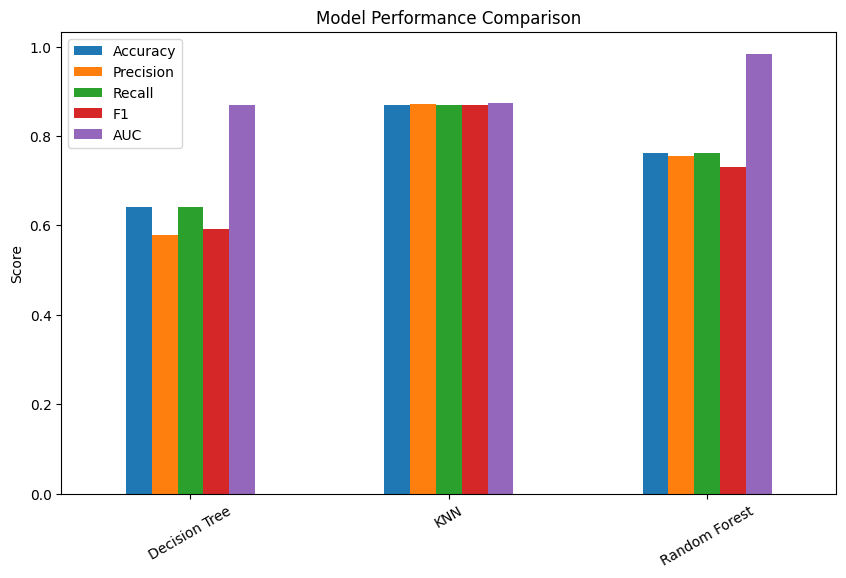

In [26]:

results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=30)
plt.show()


**Final Observation:**
- Random Forest usually performs best with balanced Precision, Recall, and F1.
- Logistic Regression is a strong baseline but weaker on complex attack patterns.
- KNN struggles with large feature space.
- Decision Tree overfits unless pruned.

 **Best model: Random Forest** due to high recall (detecting attacks) and overall robustness.